In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
vehicle_image_location=glob.glob('/data/vehicles/*/*.png')
non_vehicle_image_location=glob.glob('/data/non-vehicles/*/*.png')

vehicle_images=[]
non_vehicle_images=[]

for fname in vehicle_image_location:
    vehicle=mpimg.imread(fname)
    vehicle_images.append(vehicle)

for fname in non_vehicle_image_location:
    non_vehicle=mpimg.imread(fname)
    non_vehicle_images.append(non_vehicle)
    
print('Number of images in vehicle dataset:',len(vehicle_images))
print()
print('Number of images in Non-vehicle dataset:',len(non_vehicle_images))

Number of images in vehicle dataset: 8792

Number of images in Non-vehicle dataset: 8968


Color Histogram Features
===

In [3]:
def color_hist(img,nbins=32,bin_range=(0,256)):
    channel_1_hist=np.histogram(img[:,:,0],nbins,bin_range)
    channel_2_hist=np.histogram(img[:,:,1],nbins,bin_range)
    channel_3_hist=np.histogram(img[:,:,2],nbins,bin_range)
    
    #bin_edges=r_hist[1]
    #bin_centers=(bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    
    hist_features=np.concatenate((channel_1_hist[0],channel_2_hist[0],channel_3_hist[0]))
    return hist_features




Binary Spatial Features
===

In [4]:
def bin_spatial(img,size=(32,32)):
    
    binary_features=cv2.resize(img,size).ravel()
    
    return binary_features

"""
color_spaces=['RGB','HSV','LUV','HLS','YUV','YCrCb']
sizes=[(8,8),(16,16),(32,32)]

feature=[]
idx=0
fig,axs=plt.subplots(6,3,figsize=(30,30))
ax=axs.ravel() 
for i in range(len(color_spaces)):
    for j in range(len(sizes)):
        binary_features=bin_spatial(rgb_image,color_space=color_spaces[i],size=sizes[j])
        
        
        ax[idx].plot(binary_features)
        ax[idx].set_title(str(color_spaces[i])+' '+str(sizes[j]),fontsize=20)
        idx=idx+1
"""     

    

"\ncolor_spaces=['RGB','HSV','LUV','HLS','YUV','YCrCb']\nsizes=[(8,8),(16,16),(32,32)]\n\nfeature=[]\nidx=0\nfig,axs=plt.subplots(6,3,figsize=(30,30))\nax=axs.ravel() \nfor i in range(len(color_spaces)):\n    for j in range(len(sizes)):\n        binary_features=bin_spatial(rgb_image,color_space=color_spaces[i],size=sizes[j])\n        \n        \n        ax[idx].plot(binary_features)\n        ax[idx].set_title(str(color_spaces[i])+' '+str(sizes[j]),fontsize=20)\n        idx=idx+1\n"

HOG Features 
===

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
features=[]
def extract_features(images,color_space='RGB',size=(32,32),nbins=32,bin_range=(0,256)):
    for file in images:
        #image=mpimg.imread(file)
        image=file
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_img=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_img=cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_img=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
            elif color_space== 'YUV':
                feature_img=cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
            elif color_space=='YCrCb':
                feature_img=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        else:
            feature_img=np.copy(image)
        binary_features=bin_spatial(feature_img,size)
        hist_features=color_hist(feature_img,nbins,bin_range)
        features.append(np.concatenate((binary_features,hist_features)))
    return features
    

In [7]:
vehicle_features=extract_features(vehicle_images)
non_vehicle_features=extract_features(non_vehicle_images) 


TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

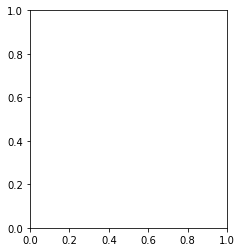

In [8]:
X = np.vstack((vehicle_features,non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind=random.randint(0,len(vehicle_images))


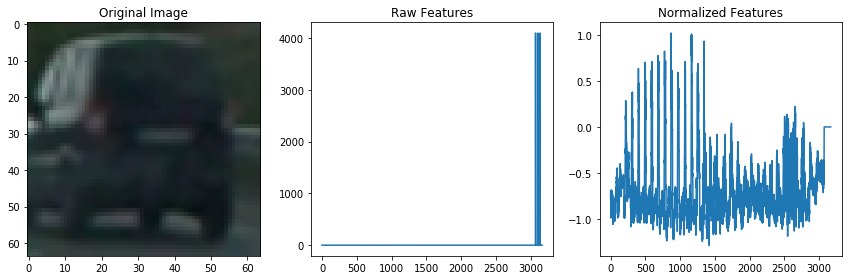

In [10]:
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(vehicle_images[car_ind])
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [15]:
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

#print('Using spatial binning of:',spatial,
#'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 3168
478.98 Seconds to train SVC...
Test Accuracy of SVC =  0.4558
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.]
0.01142 Seconds to predict 10 labels with SVC
